In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import Clean_CSV

In [2]:
import os
from torch import nn
import torch.utils.data as data
from torchvision import datasets, transforms
import torch.optim as optim
import torch

In [3]:
%reload_ext autoreload
%aimport Clean_CSV

cases_list = ['b03','b06','b09','bi001','bi01','bi1','da001','da01','da1']

cases_listmulti = ['b06pm','b09pm','bi001pm','bi01pm','da01pm']


# Loading, Cleaning Volume-Gamma-Nd dataframes

In [4]:
## Volume-Gamma data for 3-drop cases

csv_file = ['RawData/' + elem + '_GVol.csv' for elem in cases_list]
csv_names = [elem + '_csv' for elem in cases_list]

for csv, name in zip(csv_file,csv_names):
    exec(f"{name} = pd.read_csv('{csv}')")
    print('dataframe loaded:' + f"'{name}'")

dataframe loaded:'b03_csv'
dataframe loaded:'b06_csv'
dataframe loaded:'b09_csv'
dataframe loaded:'bi001_csv'
dataframe loaded:'bi01_csv'
dataframe loaded:'bi1_csv'
dataframe loaded:'da001_csv'
dataframe loaded:'da01_csv'
dataframe loaded:'da1_csv'


In [5]:
## Volume-Gamma data for multi-drop cases

csv_filemulti = ['RawData/' + elem + '_GVol.csv' for elem in cases_listmulti]
csv_names_multi = [elem + '_csv' for elem in cases_listmulti]

for csv, name in zip(csv_filemulti,csv_names_multi):
    exec(f"{name} = pd.read_csv('{csv}')")
    print('dataframe loaded:' + f"'{name}'")


dataframe loaded:'b06pm_csv'
dataframe loaded:'b09pm_csv'
dataframe loaded:'bi001pm_csv'
dataframe loaded:'bi01pm_csv'
dataframe loaded:'da01pm_csv'


In [6]:
## Dataframe cleanup

df_namescl = ['df_' + elem for elem in cases_list]

df_namescl_multi = ['df_' + elem for elem in cases_listmulti]

for dfname,csvname in zip(df_namescl,csv_names):
    exec(f"{dfname} = Clean_CSV.clean_csv({csvname},list({csvname}.columns.values)[1:3])")
    print('dataframe cleaned:' + f"'{dfname}'")
    
for dfname,csvname in zip(df_namescl_multi,csv_names_multi):
    exec(f"{dfname} = Clean_CSV.clean_csv({csvname},list({csvname}.columns.values)[1:3])")
    print('dataframe cleaned:' + f"'{dfname}'")



dataframe cleaned:'df_b03'
dataframe cleaned:'df_b06'
dataframe cleaned:'df_b09'
dataframe cleaned:'df_bi001'
dataframe cleaned:'df_bi01'
dataframe cleaned:'df_bi1'
dataframe cleaned:'df_da001'
dataframe cleaned:'df_da01'
dataframe cleaned:'df_da1'
dataframe cleaned:'df_b06pm'
dataframe cleaned:'df_b09pm'
dataframe cleaned:'df_bi001pm'
dataframe cleaned:'df_bi01pm'
dataframe cleaned:'df_da01pm'


In [7]:
## Number of drops data for 3-drop

Nd_names = ['Nd_' + elem for elem in csv_names]
Nd_csv_file = ['RawData/Nd/' + elem + '_dnum_corr.csv' for elem in cases_list]


for Nd,csv in zip(Nd_names,Nd_csv_file):
    df = pd.read_csv(csv)
    label_list = list(df.columns.values)
    df.rename(columns={label_list[0]: 'Ndrops'}, inplace=True)
    df['Time'] = df.apply(lambda row: row.name*0.005,axis=1)
    df = df[['Time','Ndrops']]
    exec(f"{Nd} = df")
    print('file loaded:' + f"'{Nd}'")


file loaded:'Nd_b03_csv'
file loaded:'Nd_b06_csv'
file loaded:'Nd_b09_csv'
file loaded:'Nd_bi001_csv'
file loaded:'Nd_bi01_csv'
file loaded:'Nd_bi1_csv'
file loaded:'Nd_da001_csv'
file loaded:'Nd_da01_csv'
file loaded:'Nd_da1_csv'


In [8]:
## Number of drops data for multi-drop

Nd_names_multi = ['Nd_' + elem for elem in csv_names_multi]
Nd_csv_file_multi = ['RawData/Nd/' + elem + '_dnum_corr.csv' for elem in cases_listmulti]


for Nd,csv in zip(Nd_names_multi,Nd_csv_file_multi):
    df = pd.read_csv(csv)
    label_list = list(df.columns.values)
    df.rename(columns={label_list[0]: 'Ndrops'}, inplace=True)
    df['Time'] = df.apply(lambda row: row.name*0.005,axis=1)
    df = df[['Time','Ndrops']]
    exec(f"{Nd} = df")
    print('file loaded:' + f"'{Nd}'")


file loaded:'Nd_b06pm_csv'
file loaded:'Nd_b09pm_csv'
file loaded:'Nd_bi001pm_csv'
file loaded:'Nd_bi01pm_csv'
file loaded:'Nd_da01pm_csv'


In [9]:
Nd_b03_csv

,Time,Ndrops
0,0.000,3
1,0.005,3
2,0.010,3
3,0.015,3
4,0.020,3
...,...,...
115,0.575,354
116,0.580,362
117,0.585,361
118,0.590,367


# RNN-LSTM with PyTorch
## Training and testing number of drops for a single case

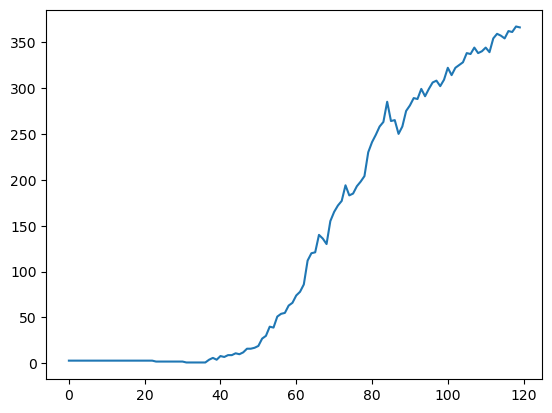

In [103]:
timeseries = Nd_b03_csv[['Ndrops']].values.astype('float32')
plt.plot(timeseries)
plt.show()

In [128]:
# OPTIONAL detrending and normalizing the linear trend
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures

X = np.arange(len(timeseries)).reshape(-1, 1)
y = timeseries.reshape(-1, 1).astype('float32')

degree = 5
poly_features = PolynomialFeatures(degree=degree)
x_poly = poly_features.fit_transform(X.reshape(-1,1))

model = LinearRegression()
model.fit(x_poly, y)

trend = model.predict(x_poly).astype('float32')

detrended = y - trend.reshape(-1,1)

min_val = np.min(detrended)
max_val = np.max(detrended)

normalized = (detrended - min_val) / (max_val - min_val)

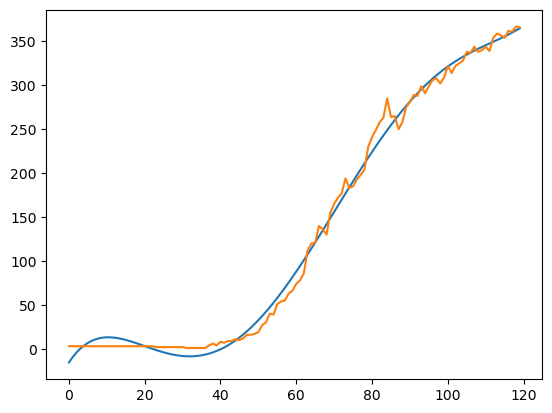

In [130]:
plt.plot(trend)
plt.plot(y)
plt.show()

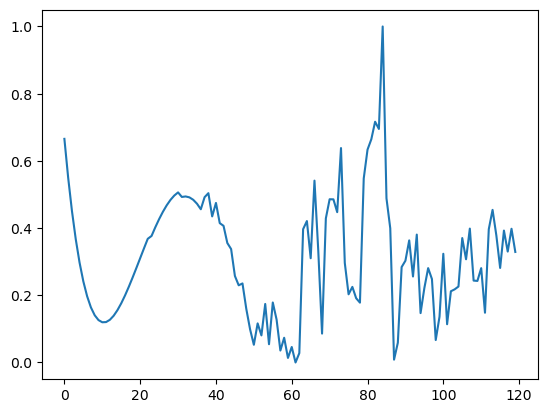

In [131]:
plt.plot(normalized)
plt.show()

In [132]:
# train-test split for time series
train_size = int(len(normalized) * 0.7)
test_size = len(normalized) - train_size
train, test = normalized[:train_size], normalized[train_size:]

In [133]:
''' Transform the time series into a prediction 
dataset based on a given window. 
Args:
        dataset: A numpy array of time series, first dimension is the time steps
        lookback: Size of window for prediction
'''
def create_dataset(dataset,lookback):
    X,y = [],[]
    for i in range(len(dataset)-lookback):
        feature = dataset[i:i+lookback]
        target = dataset[i+1:i+lookback+1]
        X.append(feature)
        y.append(target)
    return torch.tensor(X), torch.tensor(y)


In [134]:
lookback = 10
X_train, y_train = create_dataset(train, lookback=lookback)
X_test, y_test = create_dataset(test, lookback=lookback)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

torch.Size([74, 10, 1]) torch.Size([74, 10, 1])
torch.Size([26, 10, 1]) torch.Size([26, 10, 1])


### LSTM Model class creation

In [135]:
# Defining Hyperparameters
input_size = 1
hidden_size = 50
num_layers = 1
output_size = 1
num_epochs = 2000
learning_rate = 0.01

In [136]:
class LSTMModel(nn.Module):
    def __init__(self,input_size, hidden_size, output_size, num_layers):
        super(LSTMModel,self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size,hidden_size, num_layers, batch_first=True)
        self.output_layer = nn.Linear(hidden_size, output_size)
    def forward(self,x):
        out, _ = self.lstm(x)
        out = self.output_layer(out)
        return out

### Training an instance of the LSTM

In [137]:
# Instance of the LSTM model
model = LSTMModel(input_size, hidden_size, output_size, num_layers)

# Setting loss function and optimizer
loss_func = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
loader = data.DataLoader(data.TensorDataset(X_train, y_train), shuffle = True, batch_size=8)

for epoch in range(num_epochs):
    model.train()
    for X_batch, y_batch in loader:
            y_pred = model(X_batch)
            loss = loss_func(y_pred, y_batch)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

    if epoch % 100 != 0:
            continue
    model.eval()

    with torch.no_grad():
           y_pred = model(X_train)
           train_rmse = np.sqrt(loss_func(y_pred, y_train))
           y_pred = model(X_test)
           test_rmse = np.sqrt(loss_func(y_pred, y_test))
           
    print("Epoch %d: train RMSE %.4f, test RMSE %.4f" % (epoch, train_rmse, test_rmse))


Epoch 0: train RMSE 0.1606, test RMSE 0.1013
Epoch 100: train RMSE 0.0577, test RMSE 0.1379
Epoch 200: train RMSE 0.0492, test RMSE 0.1433
Epoch 300: train RMSE 0.0465, test RMSE 0.1477
Epoch 400: train RMSE 0.0399, test RMSE 0.1556
Epoch 500: train RMSE 0.0388, test RMSE 0.1565
Epoch 600: train RMSE 0.0363, test RMSE 0.1564
Epoch 700: train RMSE 0.0370, test RMSE 0.1568
Epoch 800: train RMSE 0.0349, test RMSE 0.1529
Epoch 900: train RMSE 0.0341, test RMSE 0.1576
Epoch 1000: train RMSE 0.0338, test RMSE 0.1579
Epoch 1100: train RMSE 0.0342, test RMSE 0.1539
Epoch 1200: train RMSE 0.0345, test RMSE 0.1518
Epoch 1300: train RMSE 0.0350, test RMSE 0.1514
Epoch 1400: train RMSE 0.0329, test RMSE 0.1531
Epoch 1500: train RMSE 0.0325, test RMSE 0.1519
Epoch 1600: train RMSE 0.0320, test RMSE 0.1529
Epoch 1700: train RMSE 0.0323, test RMSE 0.1544
Epoch 1800: train RMSE 0.0327, test RMSE 0.1534
Epoch 1900: train RMSE 0.0320, test RMSE 0.1512


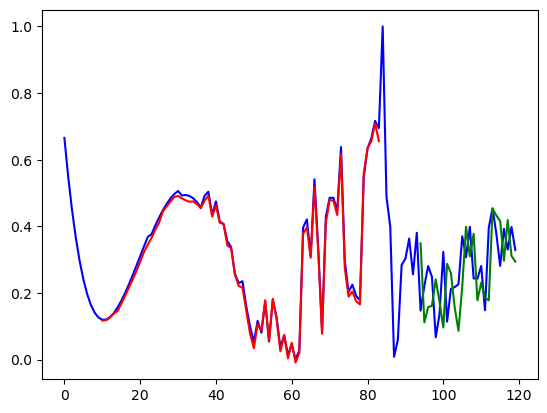

In [138]:
with torch.no_grad():
    # shift train predictions for plotting
    train_plot = np.ones_like(normalized) * np.nan
    y_pred = model(X_train)
    y_pred = y_pred[:, -1, :]
    train_plot[lookback:train_size] = model(X_train)[:, -1, :]
    # shift test predictions for plotting
    test_plot = np.ones_like(normalized) * np.nan
    test_plot[train_size+lookback:len(normalized)] = model(X_test)[:, -1, :]
# plot
plt.plot(normalized, c='b')
plt.plot(train_plot, c='r')
plt.plot(test_plot, c='g')
plt.show()